# California Policy Lab Data Assessment

> "Background:

> In January 2012, the LA County Sheriff’s Department began efforts to divert people with substance abuse or mental health issues from the criminal justice system by allowing individuals arrested for misdemeanor offenses during a substance abuse or mental health crisis to be released on bail rather than held in jail pre-trial. In addition, they also started a pilot program than ran through October 2013 to provide caseworkers and treatment to some of these individuals. The Sheriff has asked you to evaluate the effectiveness of the pilot program, and provided the data described below. The program’s manager has left the Department, so we know little about how people were assigned to it, but we do know assignment was done independently when an individual was arrested. This means that it’s possible that someone with multiple arrests could have been referred to the program on some occasions but not on others. No information is provided on take-up of services."

In [17]:
# Import our libraries.
from __future__ import division

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.tree import DecisionTreeClassifier
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.proportion import proportions_chisquare
from sklearn.model_selection import cross_val_score
from scipy.stats import ttest_ind

In [2]:
# Read in CSVs to Pandas DataFrames.
cases = pd.read_csv('case.csv')
demo = pd.read_csv('demo.csv')
prior_arrests = pd.read_csv('prior_arrests.csv')

## Part 1: Data Management

### A. Re-arrests Variable

> "The main outcome of interest is whether the defendant was arrested again prior to his/her disposition (trial or court appearance) date. Create a variable called ‘re_arrest’ that equals one if the defendant was arrested prior to trial and zero otherwise. E.g., imagine person 1 was arrested three times."

In [3]:
# Convert dates to datetime format.
cases.arrest_date = pd.to_datetime(cases.arrest_date, format="%Y-%m-%d")
cases.dispos_date = pd.to_datetime(cases.dispos_date, format="%Y-%m-%d")

# Add default re-arrests variable and set to 0.
cases['re_arrest'] = 0

# Get unique persons in cases.
persons = cases.person_id.unique()

# Loop through all persons.
for person in persons:
    
    # Get all cases belonging to a person.
    person_cases = cases[cases.person_id == person]
    num_person_cases = len(person_cases)
    
    # If only one record, re_arrest is 0.
    if num_person_cases == 1:
        continue
    
    # Otherwise, we need to check if future arrest falls inside 
    # current case's disposition window.
    else:
        
        # Sort the person's cases by arrest date ascending.
        person_cases = person_cases.sort_values(by='arrest_date')
    
        # Check only cases that have arrests in the future.
        for i in range(num_person_cases-1):
            arrest_date = person_cases.iloc[i].arrest_date
            dispos_date = person_cases.iloc[i].dispos_date
            
            # Look at all future cases for a re-arrest.
            for j in range(i+1, num_person_cases):
                
                # If future arrest falls inside current dispos window...
                if person_cases.iloc[j].arrest_date >= arrest_date and \
                   person_cases.iloc[j].arrest_date <= dispos_date:
                        
                        # Re_arrest is true!
                        cases.loc[person_cases.iloc[i].name, 're_arrest'] = 1

# Print out results.
print cases.re_arrest.describe()

count    25000.00000
mean         0.21092
std          0.40797
min          0.00000
25%          0.00000
50%          0.00000
75%          0.00000
max          1.00000
Name: re_arrest, dtype: float64


### B. Prior Arrests Variable

> "Create a variable called prior_arrests that equals the number of arrests prior to the current arrest. Assume that all of the individual’s arrests prior to the study period are contained in prior.csv. For example, if person z has five arrests in prior.csv and two in case.csv, her first arrest in case.csv should have prior_arrests = 5 and the second should have prior_arrests = 6. If someone is not included in prior_arrests.csv, assume they had zero arrests at the start of the study period."

In [4]:
# Add default re-arrests variable and set to 0.
cases['prior_arrests'] = 0

# Get sorted unique persons ids from cases.
persons = sorted(cases.person_id.unique())

# Count rows, group by person_id for number of past arrests
# to get number of prior arrests per person.
prior_arrests_counts = prior_arrests.groupby('person_id').size()

# Loop through all persons in cases.
for person in persons:
    
    # Get all cases belonging to a person from cases.
    person_cases = cases[cases.person_id == person]
    num_person_cases = len(person_cases)
    
    # Get number of prior arrests from prior_arrests.
    if person in prior_arrests_counts.index:
        prior_arrests_count = prior_arrests_counts[person]
    else:
        prior_arrests_count = 0
    
    # Sort cases by arrest date ascending.
    person_cases = person_cases.sort_values(by='arrest_date')
    
    # Add prior arrests to the cases records.
    for i in range(num_person_cases):
        
        # Set prior_arrests.
        cases.loc[person_cases.iloc[i].name, 'prior_arrests'] = prior_arrests_count
        
        # Increment arrest count.
        prior_arrests_count += 1

# Print out results.
print cases.prior_arrests.describe()

count    25000.000000
mean         3.798480
std          2.138311
min          0.000000
25%          2.000000
50%          4.000000
75%          5.000000
max         16.000000
Name: prior_arrests, dtype: float64


### C. Age Variable

> "Create an ‘age’ variable that equals the defendant’s age at the time of each arrest."

In [5]:
# Convert bdate to datetime.
demo.bdate = pd.to_datetime(demo.bdate, format="%Y-%m-%d")

# Merge cases data with demo data on person_id.
cases = pd.merge(cases, demo, how="inner", left_on="person_id", right_on="person_id")

# Calculate age at time of arrest and round to nearest int.
cases['age'] = (cases.arrest_date - cases.bdate).astype('<m8[Y]')

# Print out results.
print cases.age.describe()

count    25000.000000
mean        29.822240
std          7.799782
min          9.000000
25%         24.000000
50%         29.000000
75%         35.000000
max         70.000000
Name: age, dtype: float64


In [18]:
# Write out dataframe.
cases[['caseid', 'person_id', 'arrest_date', 'dispos_date',
       'treat', 're_arrest', 'prior_arrests', 'age']].to_csv("final_data.csv")

## Part 2: Statistical Analysis

> "Help determine whether the program should be continued/expanded by estimating its effect on re- arrests prior to disposition. Using whatever methods you feel will best answer the question, prepare a short memo (no more than two pages) with your recommendation, and your justification for it."

We should start our statistical analysis by seeing if there is a discernible effect of treatment at a global level.  For our analysis to be robust, we would have to assume that the designation of a treatment group was made at random- sampling must have been no more complicated than in the flipping of a coin or rolling of a dice.  If we wanted to be absolutely sure about this, we could run a statistical test to check for this condition by examing the covariance of demographics with treatment designation, as well as to make sure that the treatment designation method did not change over time, which we could do by making sure that there is no time lag that has correlation with treatment designation.  We might also want to run a Chi-square test for independence to make sure that demographics and recidivism did not factor into treatment designation.

Assuming treatment designation was indeed made at random over the course of the study, we would probably first want to see if the overall proportion of cases in which a person was re-arrested prior to disposition and was receiving treatment differs significantly from the overall proportion of cases in which a person was re-arrested prior to disposition and was NOT receiving treatment.  As we want to perform analysis from our data here ("a sample") to see if we can generalize results to the future or other localities ("a population"), we will move forward with a statistical inference framework.

Given the number of samples we have (> 20,000), we would want to use a two-sided z-test for the difference in the realizations of binomially-distributed outcomes. This will allow us to make inference on the null hypothesis that the treatment has no affect on the differences.

In [7]:
# Array of counts:
successes = np.array([sum(cases[cases.treat == 1].re_arrest),
                   sum(cases[cases.treat == 0].re_arrest)])

# Array of total observations.
observations = np.array([len(cases[cases.treat == 1]),
                         len(cases[cases.treat == 0])])

# Obtain test statistic and p-value.
statistic, p_value = proportions_ztest(successes, observations)

# Print results.
print "Two-sided statistic for diff. in proportions is: ", '{0:0.3f}'.format(statistic)
print "P-value for obtaining these results under null hypothesis is: ", '{0:0.3f}'.format(p_value)

Two-sided statistic for diff. in proportions is:  3.186
P-value for obtaining these results under null hypothesis is:  0.001


The result of this test suggests very strongly that the assumption of the null hypothesis can be rejected at the alpha = 0.01 level of significance, and that the difference in proportions is non-zero.  However, looking closely at this result, we see that the proportion of re-arrests is actually lower (~20.2%) for cases without treatment than those with treatment (~21.8%), which is counterintuitive to the experiment hypothesis that treatment should lower re-arrests.  This is a perplexing outcome and one that we would want to dissect, which we will do by breaking down experimental outcomes by subsets of demographics, recidivism rates, and age.

### Data Exploration

While we would want to explore treatment effects against all of our features, we will limit our exploration to just prior arrests for now, which we do by breaking down proportions of treatment designations by the number of prior arrests.

In [8]:
# Prior Arrests Breakdown
X = sorted(cases.prior_arrests.unique())[:10]
num_treated = []
num_untreated = []
y_treated = []
y_untreated = []

for num_prior_arrests in X:

    if num_prior_arrests == 9:
        treated_perc = len(cases[(cases.treat == 1) &
                                 (cases.prior_arrests >= num_prior_arrests) & 
                                 (cases.re_arrest == 1)]) / \
                       len(cases[(cases.treat == 1) & 
                                 (cases.prior_arrests >= num_prior_arrests)])

        untreated_perc = len(cases[(cases.treat == 0) & 
                                   (cases.prior_arrests >= num_prior_arrests) & 
                                   (cases.re_arrest == 1)]) / \
                         len(cases[(cases.treat == 0) & 
                                   (cases.prior_arrests >= num_prior_arrests)])
        
        num_treated.append(len(cases[(cases.treat == 1) & (cases.prior_arrests >= num_prior_arrests)]))
        num_untreated.append(len(cases[(cases.treat == 0) & (cases.prior_arrests >= num_prior_arrests)]))

    else:
        treated_perc = len(cases[(cases.treat == 1) &
                                 (cases.prior_arrests == num_prior_arrests) & 
                                 (cases.re_arrest == 1)]) / \
                       len(cases[(cases.treat == 1) & 
                                 (cases.prior_arrests == num_prior_arrests)])

        untreated_perc = len(cases[(cases.treat == 0) & 
                                   (cases.prior_arrests == num_prior_arrests) & 
                                   (cases.re_arrest == 1)]) / \
                         len(cases[(cases.treat == 0) & 
                                   (cases.prior_arrests == num_prior_arrests)])
        num_treated.append(len(cases[(cases.treat == 1) & (cases.prior_arrests == num_prior_arrests)]))
        num_untreated.append(len(cases[(cases.treat == 0) & (cases.prior_arrests == num_prior_arrests)]))

    y_treated.append(treated_perc)
    y_untreated.append(untreated_perc)

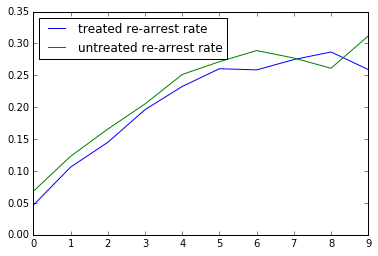

In [9]:
# Plot re_arrest rates for treated and untreated cases 
# against number of prior arrests.
plt.plot(X, y_treated)
plt.plot(X, y_untreated)

plt.legend(['treated re-arrest rate', 'untreated re-arrest rate'],
           loc='upper left')
plt.show()

This exercise shows us that the intended effects of treatment are present and consistent when broken down by prior arrests numbers.  This suggests that our trial was not random and we explore this by plotting the number of treated versus untreated cases against the number of prior arrests below.

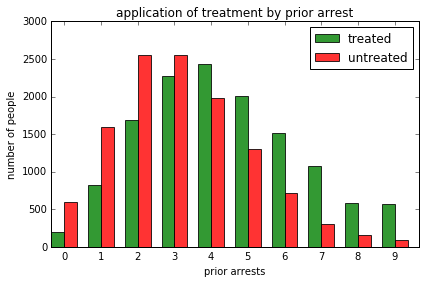

In [10]:
# Plot data.
n_groups = 10

# Create a plot.
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8
 
rects1 = plt.bar(index, num_treated, bar_width,
                 alpha=opacity,
                 color='g',
                 label='treated')
 
rects2 = plt.bar(index + bar_width, num_untreated, bar_width,
                 alpha=opacity,
                 color='r',
                 label='untreated')
 
plt.xlabel('prior arrests')
plt.ylabel('number of people')
plt.title('application of treatment by prior arrest')
plt.xticks(index + bar_width, range(10))
plt.legend()
 
plt.tight_layout()
plt.show()

We can clearly see from this chart that cases containing persons with high numbers of prior arrests are oversampled in positive treatment designation.  For sake of completeness, we will run a simple Chi-square test of independent proportions.  Our null in this case is that the treatment designation proportaion is independent of prior arrests and therefore should be equal across the range of prior arrests, as we would expect in a truly random trial.

In [11]:
# Array of counts.
successes = num_treated

# Array of total observations.
observations = [sum(x) for x in zip(num_treated, num_untreated)]

# Obtain test statistic and p-value.
statistic, p_value, _ = proportions_chisquare(successes, observations)

# Print results.
print "Chi-square statistic for diff. in proportions is: ", '{0:0.3f}'.format(statistic)
print "P-value for obtaining these results under null hypothesis is: ", '{0:0.3f}'.format(p_value)

Chi-square statistic for diff. in proportions is:  2089.818
P-value for obtaining these results under null hypothesis is:  0.000


As expected, the test statistic confirms that we cannot accept the actual treatment designation outcomes as pure chance- it is quite clear that there is embedded selection bias in the trial towards persons with higher numbers of prior arrests.  This selection bias is a confounding variable in our global analysis that might lead our research team to draw incorrect conclusions as in the intro to this analysis.  In the future, we might want to perform this same breakdown of re-arrest rates for demographics as well.

## Regression Analysis

To account for sampling bias, we need to explicity control for these factors in an analysis, which we do with an ordinary least squares regression model below.  We control for both demographics and prior arrests by casting categorical variables to bernoulli variables where appropriate, and dropping the constant term to escape the resulting multicollinearity from this approach.

In [12]:
# One-hot encode our categorical vars,
# and combine with age and treatment.
X = pd.concat([pd.get_dummies(cases.race),
               pd.get_dummies(cases.gender),
               cases.age,
               cases.prior_arrests,
               cases.treat], axis=1)

# Our dependent variable is re_arrest indicator.
y = cases.re_arrest

# Statsmodels library Ordinary Least Squares.
est = sm.OLS(y, X).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              re_arrest   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     69.20
Date:                Tue, 20 Mar 2018   Prob (F-statistic):           1.72e-99
Time:                        09:24:45   Log-Likelihood:                -12819.
No. Observations:               25000   AIC:                         2.565e+04
Df Residuals:                   24992   BIC:                         2.572e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
ASIAN             0.0111      0.010      1.081      0.279      -0.009       0.031
BLACK             0.0179      0.005      3.531      0.000       0.008       0.028
HISPANIC          0.0176      0.006      2.947      0.003       0.006       0.029
WHITE             0.0118      0.008      1.469      0.142      -0.004       0.028
F                 0.0270      0.009      3.166      0.002       0.010       0.044
M                 0.0315      0.008      4.154      0.000       0.017       0.046
age               0.0037      0.000      8.359      0.000       0.003       0.005
prior_arrests     0.0160      0.002      9.661      0.000       0.013       0.019
treat            -0.0145      0.005     -2.718      0.007      -0.025      -0.004
==============================================================================
Omnibus:                     4651.179   Durbin-Watson:                   2.108
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7890.588
Skew:                           1.376   Prob(JB):                         0.00
Kurtosis:                       3.011   Cond. No.                     1.51e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.06e-23. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

We can see through this procedure that after controlling for demographics and prior arrests, treatment has a statistically significant negative impact on the occurrance of re-arrests.  Our test statistic is -2.718, which is significant at the alpha = 0.01 level.  The coefficient of -0.0145 on the 'treat' variable can be interpreted as treatment having a -1.45% effect on occurance of re-arrest after controlling for demographics and prior arrests.

## Targeting Treatments

After determining that treatment is indeed effective at preventing re-arrests (albeit at a relatively small level), we might be interested in prescribing policy to increase the effectiveness of this treatment by targeting certain subsets of the population.  To this end, we will employ predictive analytics in the form of a supervised machine learning model to determine where to focus our treatment efforts.

### Who is likely to be re-arrested prior to disposition?

We examine the importance of demographic or prior arrests data on the likelihood of a re-arrest by training a decision tree to predict whether or not a person will be re-arrested prior to disposition on all control ("untreated") cases.

In [13]:
# Get the control cases.
untreated_cases = cases[cases.treat == 0]

# One-hot encode independent demographic and prior arrests features.
X = pd.concat([pd.get_dummies(untreated_cases.race),
               pd.get_dummies(untreated_cases.gender),
               untreated_cases.age,
               untreated_cases.prior_arrests], axis=1)

# Re-arrest is the dependent variable.
y = untreated_cases.re_arrest

# Init a vanilla decision tree classifier.
clf = DecisionTreeClassifier(max_depth = None)

# Fit a tree to the data.
clf.fit(X,y)

# Print out feature importances.
print "Features and importances:"
zip(X.columns, clf.feature_importances_)

Features and importances:


[('ASIAN', 0.04563504939761644),
 ('BLACK', 0.05591055392404558),
 ('HISPANIC', 0.0615566730747027),
 ('WHITE', 0.04880186733435068),
 ('F', 0.05567433772249244),
 ('M', 0.04488221755856354),
 ('age', 0.45016199423042474),
 ('prior_arrests', 0.23737730675780394)]

This exercise shows us that age and prior_arrests are significantly more "important" in predicting a re-arrest as determined by a measure of entropy-reduction from the construction of a complete-fit decision tree classifier to the untreated data.  In particular, both age and prior arrests have a positive correlation with re-arrests, suggesting that older persons with many prior arrests are at a higher risk of being re-arrested than their younger, infrequently arrested counterparts.

In [14]:
print "Age/Re-arrest correlation for untreated cases."
print np.corrcoef(untreated_cases.age, untreated_cases.re_arrest)
print
print "Prior Arrests/Re-arrest correlation for untreated cases."
print np.corrcoef(untreated_cases.prior_arrests, untreated_cases.re_arrest)

Age/Re-arrest correlation for untreated cases.
[[1.         0.12446435]
 [0.12446435 1.        ]]

Prior Arrests/Re-arrest correlation for untreated cases.
[[1.         0.14242233]
 [0.14242233 1.        ]]


We now look at the demographic and prior arrest characteristics of "effective" treatment cases versus "ineffective" treatment cases to see if there are fundamental differences in the profile of a person that responds positively to the treatment program.  We choose a multi-variate two sided t-test statistic for our differences.

In [15]:
# Get treated cases and split by effective/ineffective.
treated_cases = cases[cases.treat == 1]
effective_cases = treated_cases[treated_cases.re_arrest == 0]
ineffective_cases = treated_cases[treated_cases.re_arrest == 1]

# One-hot encode both sets of independent variables.
X1 = pd.concat([pd.get_dummies(ineffective_cases.race), pd.get_dummies(ineffective_cases.gender), ineffective_cases.age, ineffective_cases.prior_arrests], axis=1)
X2 = pd.concat([pd.get_dummies(effective_cases.race), pd.get_dummies(effective_cases.gender), effective_cases.age, effective_cases.prior_arrests], axis=1)

# Perform standard t-test for all dependent variables.
print "Characteristic : Statistic : p-value"
for characteristic in X1.columns:
    stat, pval = ttest_ind(X1[characteristic], X2[characteristic], axis=0, equal_var=False)
    print characteristic, ": ", '{0:0.3f}'.format(stat), ': {0:0.3f}'.format(pval)

# Print out results.
print '\nAverage age of effective treatment cases: {0:0.1f}'.format(np.mean(effective_cases.age))
print 'Average age of ineffective treatment cases: {0:0.1f}'.format(np.mean(ineffective_cases.age))
print 'Average prior arrests of effective treatment cases: {0:0.1f}'.format(np.mean(effective_cases.prior_arrests))
print 'Average prior arrests of ineffective treatment cases: {0:0.1f}'.format(np.mean(ineffective_cases.prior_arrests))

Characteristic : Statistic : p-value
ASIAN :  -0.001 : 0.999
BLACK :  0.475 : 0.635
HISPANIC :  -0.532 : 0.595
WHITE :  -0.011 : 0.991
F :  0.093 : 0.926
M :  -0.093 : 0.926
age :  13.462 : 0.000
prior_arrests :  13.639 : 0.000

Average age of effective treatment cases: 30.8
Average age of ineffective treatment cases: 33.1
Average prior arrests of effective treatment cases: 4.2
Average prior arrests of ineffective treatment cases: 4.9


This exercise shows that while race and gender do not appear to play a role in the effectiveness of treatment on the re-arrest rates of persons prior to disposition, age and prior arrests in fact do play a role.

### Who is likely to respond positively to treatment?

While we expect younger, less-frequently-arrested persons to not be re-arrested at the same rate, we want to tease out the effects treatment at the subgroup level for policy purposes.

We now split out an example of a "high-risk" group from a "low-risk" group to see if treatment had a tangible difference on the re-arrest occurances for these subgroups.  We perform a simple z-test for differences in proportions as our statistic.

In [16]:
# Split out low risk group.
lowrisk_cases = cases[(cases.age <= 30) & (cases.prior_arrests <= 4)]
treated_lowrisk = lowrisk_cases[lowrisk_cases.treat == 1]
untreated_lowrisk = lowrisk_cases[lowrisk_cases.treat == 0]

# Split out high risk group.
highrisk_cases = cases[(cases.age > 30) & (cases.prior_arrests > 4)]
treated_highrisk = highrisk_cases[highrisk_cases.treat == 1]
untreated_highrisk = highrisk_cases[highrisk_cases.treat == 0]

# Calculate proportions for risk group responses.
rearrest_proportion_treated_lowrisk = len(treated_lowrisk[treated_lowrisk.re_arrest == 1]) / \
                                      len(treated_lowrisk)
rearrest_proportion_untreated_lowrisk = len(untreated_lowrisk[untreated_lowrisk.re_arrest == 1]) / \
                                        len(untreated_lowrisk)
rearrest_proportion_treated_highrisk = len(treated_highrisk[treated_highrisk.re_arrest == 1]) / \
                                       len(treated_highrisk)
rearrest_proportion_untreated_highrisk = len(untreated_highrisk[untreated_highrisk.re_arrest == 1]) / \
                                         len(untreated_highrisk)

# Array of counts:
successes_lowrisk = np.array([len(treated_lowrisk[treated_lowrisk.re_arrest == 1]),
                              len(untreated_lowrisk[untreated_lowrisk.re_arrest == 1])])
successes_highrisk = np.array([len(treated_highrisk[treated_highrisk.re_arrest == 1]),
                               len(untreated_highrisk[untreated_highrisk.re_arrest == 1])])

# Array of total observations.
observations_lowrisk = np.array([len(treated_lowrisk),
                                 len(untreated_lowrisk)])
observations_highrisk = np.array([len(treated_highrisk),
                                  len(untreated_highrisk)])

# Obtain test statistics and p-values.
statistic_lr, p_value_lr = proportions_ztest(successes_lowrisk, observations_lowrisk)
statistic_hr, p_value_hr = proportions_ztest(successes_highrisk, observations_highrisk)

# Print low risk group statistics.
print "Low Risk Group Response:"
print "Re-arrest rate for treated low-risk persons: {0:0.3f}".format(rearrest_proportion_treated_lowrisk)
print "Re-arrest rate for untreated low-risk persons: {0:0.3f}".format(rearrest_proportion_untreated_lowrisk)
print "Test statistic for difference in responses is {0:0.3f}".format(statistic_lr)
print "P-value for difference in responses is {0:0.3f}".format(p_value_lr)

# Print high risk group statistics.
print "\nHigh Risk Group Response:"
print "Re-arrest rate for treated low-risk persons: {0:0.3f}".format(rearrest_proportion_treated_highrisk)
print "Re-arrest rate for untreated low-risk persons: {0:0.3f}".format(rearrest_proportion_untreated_highrisk)
print "Test statistic for difference in responses is {0:0.3f}".format(statistic_hr)
print "P-value for difference in responses is {0:0.3f}".format(p_value_hr)

Low Risk Group Response:
Re-arrest rate for treated low-risk persons: 0.170
Re-arrest rate for untreated low-risk persons: 0.168
Test statistic for difference in responses is 0.295
P-value for difference in responses is 0.768

High Risk Group Response:
Re-arrest rate for treated low-risk persons: 0.280
Re-arrest rate for untreated low-risk persons: 0.295
Test statistic for difference in responses is -1.262
P-value for difference in responses is 0.207


We see from this exercise that although low-risk groups tend not to be re-arrested at the same rates as their high-risk counterparts, the effect of treatment appears to be negligible.  The effect of treatment for high-risk groups is more prevalent- however, the selection bias in the application of treatment designations for high risk groups renders our test statistics inconclusive as high risk persons were oversampled in the trial, leaving us with small control samples to compare our treatment groups against.

### Final Words and Policy Suggestions

In this brief examination of the re-arrest treatment program, we showed that statistical inference applied to the whole period in question will be erroneous due to selection bias in the application of treatment towards persons with higher prior arrests records.  We showed that after explicit controlling for demographics and prior arrests, treatment appears to be effective but marginal across the range of persons as determined by a multivariate regression analysis.  We continued to show that both age and prior arrests (as opposed to race and gender) appear to explain to a large degree re-arrest outcomes, with older, more-frequently-arrested persons at higher risk for re-arrests.  Finally, we showed that while younger, less-frequently-arrested persons do not appear to respond to treatment, high risk groups do appear to respond, but the results are inconclusive do to sampling bias.

With this analysis, we state that if this program were to continue, we would expect the most-efficient use of resources as adjudged by positive treatment outcomes to occur for older, more-frequently arrested persons, but that we would need a more-controlled experiment to make conclusive results.  We also suggest that the costs of the program be weighed against the minor overall decreases in re-arrest rates.  While the treatment program appears promising, the results are not significant enough to declare it a unequivocal success.